##  Reproducing Chapter 4.6 from Langtangen, Logg

### Import packages

In [12]:
from fenics import *
from mshr import *
from math import sin, cos, pi
%matplotlib inline

### Set the domain

In [13]:
a = 1.0 # inner radius of iron cylinder
b = 1.2 # outer radius of iron cylinder
c_1 = 0.8 # radius for inner circle of copper wires
c_2 = 1.4 # radius for outer circle of copper wires
r = 0.1 # radius of copper wires
R = 5.0 # radius of domain
n = 10 # number of windings

# Define geometry for background
domain = Circle(Point(0, 0), R)

# Define geometry for iron cylinder
cylinder = Circle(Point(0, 0), b) - Circle(Point(0, 0), a)

# Define geometry for wires (N = North (up), S = South (down))
angles_N = [i*2*pi/n for i in range(n)]
angles_S = [(i + 0.5)*2*pi/n for i in range(n)]
wires_N = [Circle(Point(c_1*cos(v), c_1*sin(v)), r) for v in angles_N]
wires_S = [Circle(Point(c_2*cos(v), c_2*sin(v)), r) for v in angles_S]

# Set subdomain for iron cylinder
domain.set_subdomain(1, cylinder)

# Set subdomains for wires
for (i, wire) in enumerate(wires_N):
    domain.set_subdomain(2 + i, wire)
for (i, wire) in enumerate(wires_S):
    domain.set_subdomain(2 + n + i, wire)

### Create mesh and function spaces

In [14]:
# Create mesh
mesh = generate_mesh(domain, 32)

# Define function space
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
bc = DirichletBC(V, Constant(0), 'on_boundary')

# Define subdomain markers and integration measure
markers = MeshFunction('size_t', mesh, 2, mesh.domains())
dx = Measure('dx', domain=mesh, subdomain_data=markers)

# Define current densities
J_N = Constant(1.0)
J_S = Constant(-1.0)

# Modifications according to https://fenicsproject.discourse.group/t/recursionerror-maximum-recursion-depth-exceeded-in-the-ft11-magnetostatics-py-example-of-the-solving-pdes-in-python-the-fenics-tutorial-part-1/1559/2
class Permeability(UserExpression):
    def __init__(self, markers, **kwargs):
        super().__init__(**kwargs)
        self.markers = markers
    def eval_cell(self, values, x, cell):
        if self.markers[cell.index] == 0:
            values[0] = 4*pi*1e-7 # vacuum
        elif self.markers[cell.index] == 1:
            values[0] = 1e-5      # iron (should really be 6.3e-3)
        else:
            values[0] = 1.256629e-6   # copper (https://www.engineeringtoolbox.com/permeability-d_1923.html)
            #values[0] = -6.4e-6 # copper (yes, it’s negative!) NO IT'S NOT YOU FOOL!!!
            
mu = Permeability(markers, degree=1)

### Solve variational problem

In [15]:
# Define variational problem
A_z = TrialFunction(V)
v = TestFunction(V)
a = (1 / mu)*dot(grad(A_z), grad(v))*dx
L_N = sum(J_N*v*dx(i) for i in range(2, 2 + n))
L_S = sum(J_S*v*dx(i) for i in range(2 + n, 2 + 2*n))
L = L_N + L_S

# Solve variational problem
A_z = Function(V)
solve(a == L, A_z, bc)

# Compute magnetic field (B = curl A)
W = VectorFunctionSpace(mesh, 'P', 1)
B = project(as_vector((A_z.dx(1), -A_z.dx(0))), W)

### Visualize

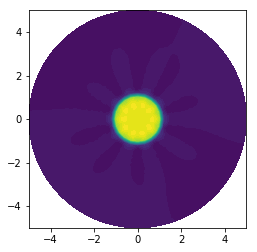

In [16]:
plot(A_z)

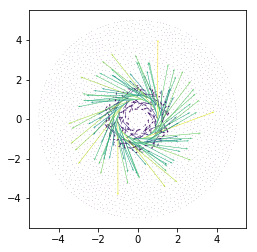

In [17]:
plot(B)

In [18]:
# Save solution to file
#vtkfile_A_z = File('magnetostatics/potential.pvd')
#vtkfile_B = File('magnetostatics/field.pvd')
#vtkfile_A_z << A_z
#vtkfile_B << B